In [51]:
import os
import sys

In [52]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [53]:
sys.path.append("../../../deep-learning-dna")
sys.path.append("../")

In [54]:
import wandb

In [55]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import math
import string

from Attention import Set_Transformer 
from common.models import dnabert
from common import dna
from lmdbm import Lmdb
from common.data import DnaSequenceGenerator, DnaLabelType, DnaSampleGenerator, find_dbs
import wandb

import tf_utilities as tfu

In [56]:
strategy = tfu.devices.select_gpu(0, use_dynamic_memory=True)

---
# Load Data

## MNIST dataset

In [57]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [58]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [59]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


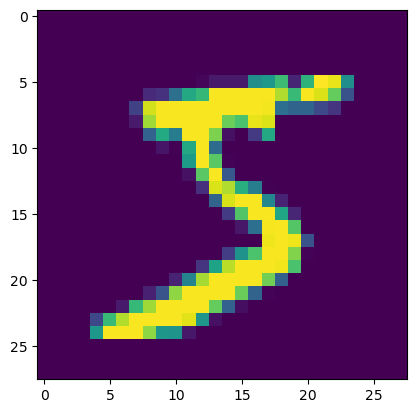

In [60]:
plt.imshow(x_train[0])

## MNIST Point Cloud Generation

In [61]:
class MnistPointCloudGenerator(keras.utils.Sequence):

    def __init__(self, x, y=None, num_points=1000, batch_size=32, threshold=70, shuffle=True, rng=None):
        self.x = x
        self.y = y.astype(np.int32) if y is not None else None
        self.num_points = num_points
        self.batch_size = batch_size if batch_size is not None else len(x)
        self.threshold = threshold
        self.should_shuffle = shuffle
        self.rng = rng if rng is not None else np.random.default_rng()

        self.num_batches = len(self.x) // self.batch_size

        self.init()
        self.shuffle()

    def init(self):
        img_ids, y_pixels, x_pixels = np.nonzero(self.x > self.threshold)
        self.pixels = (np.column_stack((x_pixels, 28 - y_pixels)) - 13.5) / 13.5
        _, self.pixel_counts = np.unique(img_ids, return_counts=True)
        self.pixel_offsets = np.concatenate(([0], np.cumsum(self.pixel_counts)))

    def shuffle(self):
        # Randomize the order of the images
        num_elems = self.num_batches*self.batch_size
        if self.shuffle:
            self.indices = np.reshape(self.rng.permutation(len(self.x))[:num_elems], (-1, self.batch_size))
        else:
            self.indices = np.reshape(np.arange(num_elems), (-1, self.batch_size))

        # Select random pixel indices
        noise = self.rng.uniform(size=(len(self.x), self.num_points))
        self.pixel_indices = (noise * np.reshape(self.pixel_counts, (-1, 1))).astype(np.int64) \
                           + np.reshape(self.pixel_offsets[:-1], (-1, 1))

        # Generate noise for the pixels
        self.pixel_noise = self.rng.normal(size=(len(self.x), self.num_points, 2), scale=1/13.5/2)

    def __len__(self):
        return self.num_batches

    def __getitem__(self, batch_index):
        indices = self.indices[batch_index]
        batch_x = self.pixels[self.pixel_indices[indices]] + self.pixel_noise[indices]
        if self.y is not None:
            return batch_x, self.y[indices]
        return batch_x

    def on_epoch_end(self):
        self.shuffle()

In [62]:
dataset = MnistPointCloudGenerator(x_train, y_train)

In [63]:
point_clouds, labels = dataset[0] # fetch a batch
print(point_clouds.shape, labels.shape)

(32, 1000, 2) (32,)


The digit is a 2


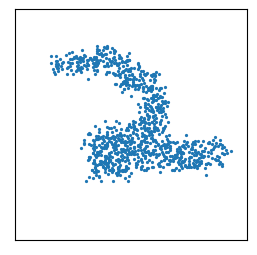

In [64]:
index = 1 # the index of the batch to show

print("The digit is a", labels[index])

plt.figure(figsize=(3, 3))
plt.scatter(*point_clouds[index].T, s=1.7)
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.xticks([])
plt.yticks([])
plt.show()

---
# Set Transformer Class

In [65]:
class Set_Transformer_Model(keras.Model):
    def __init__(self, num_induce, embed_dim, attention_num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, num_seeds, pooling_num_heads):
        super(Set_Transformer_Model, self).__init__()
        
        self.num_induce = num_induce
        self.embed_dim = embed_dim
        self.attention_num_heads = attention_num_heads
        self.stack = stack
        self.use_layernorm = use_layernorm
        self.pre_layernorm = pre_layernorm
        self.use_keras_mha = use_keras_mha
        self.num_seeds = num_seeds 
        self.pooling_num_heads = pooling_num_heads
        
        self.linear_layer = keras.layers.Dense(self.embed_dim)
        self.attention_blocks = []
        
        if self.num_induce == 0:
            for i in range(self.stack):
                self.attention_blocks.append(Set_Transformer.SetAttentionBlock(embed_dim=self.embed_dim,num_heads=self.attention_num_heads,use_layernorm=self.use_layernorm,pre_layernorm=self.pre_layernorm,use_keras_mha=self.use_keras_mha))
        else:
            for i in range(self.stack):
                self.attention_blocks.append(Set_Transformer.InducedSetAttentionBlock(embed_dim=self.embed_dim,num_heads=self.attention_num_heads, num_induce=self.num_induce, use_layernorm=self.use_layernorm,pre_layernorm=self.pre_layernorm,use_keras_mha=self.use_keras_mha))

        self.pooling_layer = Set_Transformer.PoolingByMultiHeadAttention(num_seeds=self.num_seeds,embed_dim=self.embed_dim,num_heads=self.pooling_num_heads,use_layernorm=self.use_layernorm,pre_layernorm=self.pre_layernorm,use_keras_mha=self.use_keras_mha,is_final_block=True)
    
        self.reshape_layer = keras.layers.Reshape((embed_dim,))
        
        self.dropout_layer = keras.layers.Dropout(.5)
        
        self.dense_layer = keras.layers.Dense(10)                                       
    
    def call(self, data):
        
            linear_transform = self.linear_layer(data)
            
            attention = linear_transform
            
            for attention_block in self.attention_blocks:
                attention = attention_block([attention, None])
                
            dropout = self.dropout_layer(attention)
                
            pooling = self.pooling_layer(dropout)
            
            dropout = self.dropout_layer(pooling)
            
            reshape = self.reshape_layer(dropout)
            
            output = self.dense_layer(reshape)
            
            return output

---
## 1000-Element Point Clouds

### Dataset

In [66]:
split_index = int(0.2*len(x_train))

train_dataset = MnistPointCloudGenerator(x_train[split_index:], y_train[split_index:], num_points=1000)
val_dataset = MnistPointCloudGenerator(x_train[:split_index], y_train[:split_index], num_points=1000)
test_dataset = MnistPointCloudGenerator(x_test, y_test, num_points=1000)


---
# Create Model

In [67]:
#Hyperparameters
num_induce = 0
embed_dim = 32
attention_num_heads = 4
stack = 2
use_layernorm = True
pre_layernorm = True
use_keras_mha = True
num_seeds = 1
pooling_num_heads = 1

In [68]:
model = Set_Transformer_Model(num_induce, embed_dim, attention_num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, num_seeds, pooling_num_heads)
model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

In [69]:
v = model.predict(train_dataset[0][0])

1/1 [==============================] - 1s 525ms/step


In [70]:
epochs = 30

In [71]:
run = wandb.init(project = "Str_MNIST")

In [ ]:
model_path = "Str_MNIST"
wandb_callback = wandb.keras.WandbCallback(save_model=False)
wandb_callback.save_model_as_artifact = False

model.fit(x=train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1, callbacks=[wandb_callback])

import pickle

with open(model_path, "wb") as f:
            pickle.dump(model.get_weights(), f)

Epoch 1/30
1375/1500 [==========================>...] - ETA: 10s - loss: 1.0053 - sparse_categorical_accuracy: 0.6676

In [ ]:
1

In [ ]:
run.finish()